In [181]:
import nilearn
from nibabel.testing import data_path
from nilearn import datasets, plotting, regions
import brainspace
import pandas as pd
import numpy as np
import os
from nilearn import surface
import nibabel as nib
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#import hcp_utils as hcp
from sklearn.neighbors import NearestNeighbors
from brainspace.gradient import GradientMaps
from brainspace.gradient.alignment import ProcrustesAlignment
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
from surfplot import plotting
import seaborn as sns
from surfplot.plotting import Plot
import hcp_utils as hcp
from icc_utils import *
from hyppo.discrim import DiscrimOneSample
from hyppo.independence import Dcorr

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [187]:
def parcellate_margulies(grads, n_grad = 26, parc = "schaefer", n_parc = 1000):
    
    parcellation = load_parcellation(parc, scale=n_parc, join=True)
    margulies_grads = nib.load(grads).get_fdata()[:n_grad, :]
    margulies_grads = np.array([hcp.cortex_data(i) for i in margulies_grads])
    parc_grads = np.array([reduce_by_labels(i, parcellation) for i in margulies_grads])
    return parc_grads


In [193]:
margulies_grads3_schaefer_1000 = parcellate_margulies('HCP/Gradients_Margulies2016/hcp.gradients.dscalar.nii', 3)
margulies_grads4_schaefer_1000 = parcellate_margulies('HCP/Gradients_Margulies2016/hcp.gradients.dscalar.nii', 4)
margulies_grads5_schaefer_1000 = parcellate_margulies('HCP/Gradients_Margulies2016/hcp.gradients.dscalar.nii', 5)
margulies_grads6_schaefer_1000 = parcellate_margulies('HCP/Gradients_Margulies2016/hcp.gradients.dscalar.nii', 6)

## After `reduce_by_labels`

In [3]:
path = 'HCP/schaefer1000'

In [4]:
hcp_subjects = os.listdir(path)
hcp_subjects.remove('.DS_Store')

In [5]:
margulies_grads_schaefer1000 = np.load("margulies_grads_schaefer1000.npy")

In [6]:
schaefer_labels_1000_split = load_parcellation("schaefer", 1000, join = False)

In [7]:
LR_indices = np.unique(schaefer_labels_1000_split[0])
RL_indices = np.unique(schaefer_labels_1000_split[1])

In [13]:
subject = '100307'
subj_ts = np.load(f"{path}/{subject}/func/{subject}_concat_ts_schaefer1000.npy").T
ts_batch1 = np.concatenate((subj_ts[:, :1200], subj_ts[:, 3600:]), axis = 1) # concat LR from 1 ses and RL from 2nd ses
ts_batch2 = np.concatenate((subj_ts[:, 1200:2400], subj_ts[:, 2400:3600]), axis = 1)# concat LR form 2 ses and RL from 1nd ses

## Compute Matrices

In [14]:
for subject in hcp_subjects:
    subj_ts = np.load(f"{path}/{subject}/func/{subject}_concat_ts_schaefer1000.npy").T

    ts_batch1 = np.concatenate((subj_ts[:, :1200], subj_ts[:, 3600:]), axis = 1) # concat LR from 1 ses and RL from 2nd ses
    ts_batch2 = np.concatenate((subj_ts[:, 1200:2400], subj_ts[:, 2400:3600]), axis = 1) # concat LR form 2 ses and RL from 1nd ses

    conn_mat_batch1 = np.corrcoef(ts_batch1)
    conn_mat_batch2 = np.corrcoef(ts_batch2)

    np.save(f'{path}/{subject}/func/conn_matrix_ses1_{subject}_schaefer1000', conn_mat_batch1)
    np.save(f'{path}/{subject}/func/conn_matrix_ses2_{subject}_schaefer1000', conn_mat_batch2)

    conn_mat_batch1_std =np.arctanh(conn_mat_batch1)
    conn_mat_batch2_std =np.arctanh(conn_mat_batch2)

    np.save(f'{path}/{subject}/func/z_conn_matrix_ses1_{subject}_schaefer1000', conn_mat_batch1_std)
    np.save(f'{path}/{subject}/func/z_conn_matrix_ses2_{subject}_schaefer1000', conn_mat_batch2_std)


/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_34243/1646471058.py:13: RuntimeWarning: divide by zero encountered in arctanh
  conn_mat_batch1_std =np.arctanh(conn_mat_batch1)
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_34243/1646471058.py:14: RuntimeWarning: divide by zero encountered in arctanh
  conn_mat_batch2_std =np.arctanh(conn_mat_batch2)


## Compute Gradients: Cosine + PCA

In [176]:
for subject in hcp_subjects:
    z_corr_ses1 = np.load(f'{path}/{subject}/func/z_conn_matrix_ses1_{subject}_schaefer1000.npy')
    z_corr_ses2 = np.load(f'{path}/{subject}/func/z_conn_matrix_ses2_{subject}_schaefer1000.npy')
    zcorrs = [z_corr_ses1, z_corr_ses2]
    for i, zcorr in enumerate(zcorrs):
        if np.isnan(zcorr).any():
            nan_indices = np.where(np.isnan(zcorr))
            zcorr[nan_indices] = .0000000001
        if np.isinf(zcorr).any():
            inf_indices = np.where(np.isinf(zcorr))
            zcorr[inf_indices] = 1
        gm = GradientMaps(n_components=4, kernel = "cosine", approach= 'pca')
        gm.fit(zcorr)
        np.save(f'{path}/{subject}/func/gradients_sub-{subject}-ses{i + 1}', gm.gradients_)


GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

GradientMaps(approach='pca', kernel='cosine', n_components=4)

## Align

In [195]:
for subject in hcp_subjects:
    for i in range(1, 3):
        gradients = np.load(f'{path}/{subject}/func/gradients_sub-{subject}-ses{i}.npy')
        alignment = ProcrustesAlignment(verbose=True)
        aligned_gradients = alignment.fit(np.expand_dims(gradients, axis = 0), margulies_grads4_schaefer_1000.T)
        np.save(f'{path}/{subject}/func/aligned_4gradients_ses{i}_{subject}_schaefer1000', aligned_gradients.aligned_[0])

Iteration   0: 8916.311531
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 8269.921400
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 11557.236135
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 9249.014331
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 10762.948827
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 8705.719257
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 10000.542499
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 9914.519712
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 9857.380044
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 9443.977579
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 11222.929789
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 9226.520253
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 7948.805444
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   0: 8236.6

## Discriminability of aligned gradients

In [197]:
np.load('/Users/VictoriaShevchenko/Documents/PhD/HCP/schaefer1000/103414/func/aligned_4gradients_ses1_103414_schaefer1000.npy').shape

(1000, 4)

## Visualize

In [198]:
schaefer_labels_1000 = load_parcellation('schaefer', scale=1000, join=True)

In [199]:
subject = '103414'
grad_ses1 = np.load(f'{path}/{subject}/func/aligned_4gradients_ses1_{subject}_schaefer1000.npy')
grad_ses2 = np.load(f'{path}/{subject}/func/aligned_4gradients_ses2_{subject}_schaefer1000.npy')



grad_mapped_ses1 = [None]  * 4
for i, g in enumerate(grad_ses1.T):
    grad_mapped_ses1[i] = map_to_labels(g, schaefer_labels_1000, mask=schaefer_labels_1000 != 0, fill=np.nan)

grad_mapped_ses2 = [None]  * 4
for i, g in enumerate(grad_ses2.T):
    grad_mapped_ses2[i] = map_to_labels(g, schaefer_labels_1000, mask=schaefer_labels_1000 != 0, fill=np.nan)

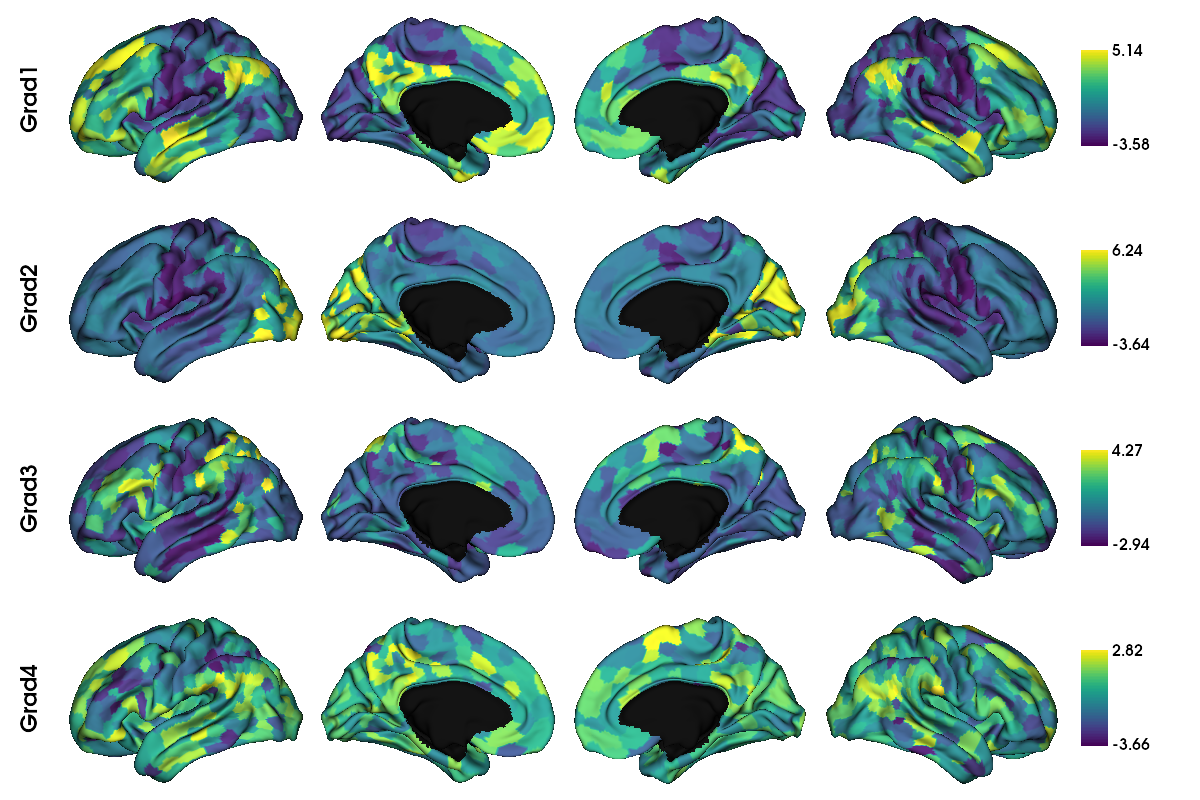

In [201]:
surf_lh, surf_rh = load_conte69()
plot_hemispheres(surf_lh, surf_rh, array_name=grad_mapped_ses1, size=(1200, 800), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3', 'Grad4'], zoom=1.5, embed_nb = True)

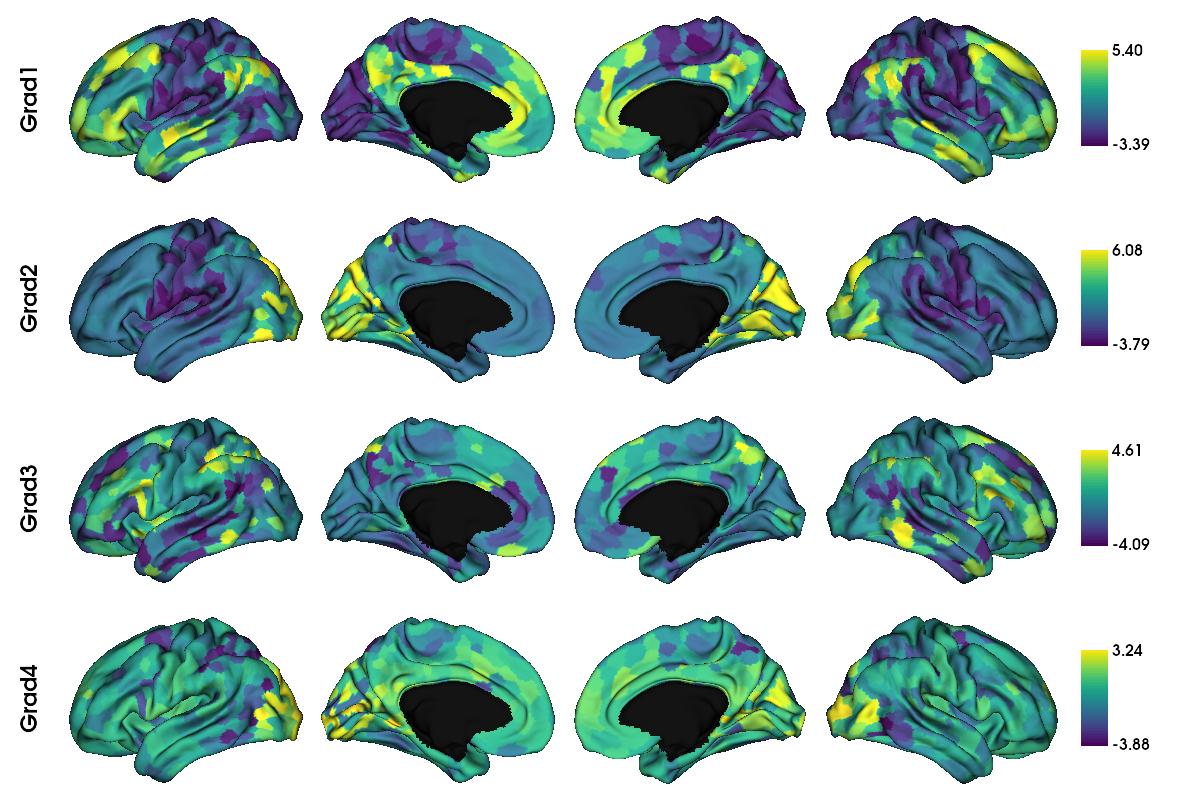

In [202]:


plot_hemispheres(surf_lh, surf_rh, array_name=grad_mapped_ses2, size=(1200, 800), cmap='viridis',
                 color_bar=True, label_text=['Grad1', 'Grad2', 'Grad3', 'Grad4'], zoom=1.5, embed_nb = True)

## Discriminability of the 1st gradient

#### Example from `hyppo`: perfect discriminability

In [85]:
# EXAMPLE 

x = np.concatenate([np.zeros((85, 1000)), np.ones((85, 1000))], axis=0)
y = np.concatenate([np.zeros(85), np.ones(85)], axis=0)

example_result = DiscrimOneSample().test(x, y, workers=-1) 

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Perfect Discriminability')

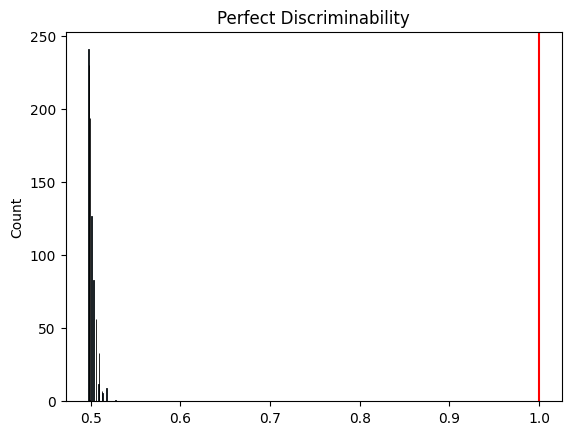

In [86]:
v

#### 1st Gradient

In [209]:
ses_labels = np.concatenate([np.zeros(len(hcp_subjects)), np.ones(len(hcp_subjects))], axis=0)
grad1_ses1 = np.stack([np.load(f'{path}/{subject}/func/aligned_4gradients_ses1_{subject}_schaefer1000.npy')[:, 0] for subject in hcp_subjects])
grad1_ses2 = np.stack([np.load(f'{path}/{subject}/func/aligned_4gradients_ses2_{subject}_schaefer1000.npy')[:, 0] for subject in hcp_subjects])

grad2_ses1 = np.stack([np.load(f'{path}/{subject}/func/aligned_4gradients_ses1_{subject}_schaefer1000.npy')[:, 1] for subject in hcp_subjects])
grad2_ses2 = np.stack([np.load(f'{path}/{subject}/func/aligned_4gradients_ses2_{subject}_schaefer1000.npy')[:, 1] for subject in hcp_subjects])

grad3_ses1 = np.stack([np.load(f'{path}/{subject}/func/aligned_4gradients_ses1_{subject}_schaefer1000.npy')[:, 2] for subject in hcp_subjects])
grad3_ses2 = np.stack([np.load(f'{path}/{subject}/func/aligned_4gradients_ses2_{subject}_schaefer1000.npy')[:, 2] for subject in hcp_subjects])

grad4_ses1 = np.stack([np.load(f'{path}/{subject}/func/aligned_4gradients_ses1_{subject}_schaefer1000.npy')[:, 3] for subject in hcp_subjects])
grad4_ses2 = np.stack([np.load(f'{path}/{subject}/func/aligned_4gradients_ses2_{subject}_schaefer1000.npy')[:, 3] for subject in hcp_subjects])

grad1 = np.row_stack((grad1_ses1, grad1_ses2))
grad2 = np.row_stack((grad2_ses1, grad2_ses2))
grad3 = np.row_stack((grad3_ses1, grad3_ses2))
grad4 = np.row_stack((grad4_ses1, grad4_ses2))


In [205]:
grad1_ses1.shape

(85, 1000)

In [210]:
grad_discrim=[]
for grad in [grad1, grad2, grad3, grad4]:
    discrim = DiscrimOneSample().test(grad, ses_labels, workers=-1)
    grad_discrim.append(discrim)


In [218]:
grad_discrim[0]

DiscrimOneSampleTestOutput(stat=0.5091860273521173, pvalue=0.012987012987012988, null_dist=array([0.50095403, 0.49723925, 0.50066568, 0.49887378, 0.49574724,
       0.50167243, 0.49478827, 0.49787032, 0.49822294, 0.49465151,
       0.49840254, 0.49811748, 0.49765612, 0.49650684, 0.49696161,
       0.49792717, 0.49888779, 0.49679189, 0.50246993, 0.49910611,
       0.50370489, 0.4980112 , 0.50374609, 0.50089142, 0.49829791,
       0.49849234, 0.50513511, 0.49733976, 0.49654144, 0.49761493,
       0.50029824, 0.49764706, 0.50132888, 0.50201351, 0.49482617,
       0.50264459, 0.49894793, 0.49901961, 0.49870572, 0.5007942 ,
       0.49817103, 0.50134454, 0.4991506 , 0.49816032, 0.50315538,
       0.49834075, 0.49876833, 0.50282584, 0.49837205, 0.50105207,
       0.4959392 , 0.50134124, 0.50398253, 0.49629016, 0.50172022,
       0.50547537, 0.50280854, 0.4974205 , 0.50133136, 0.50038557,
       0.50293047, 0.50095156, 0.49723925, 0.50212803, 0.50116823,
       0.49713297, 0.49942824, 0.50558

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Gradient 1 Discriminability')

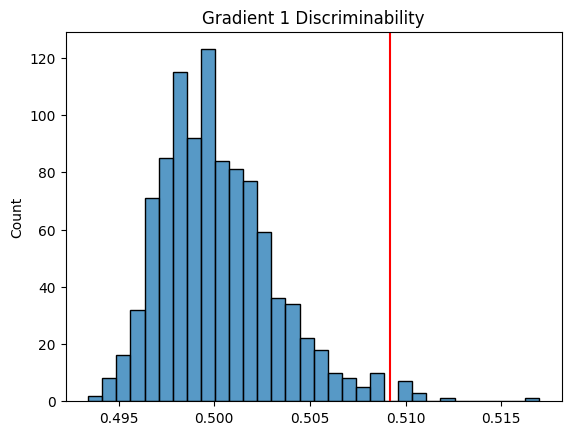

In [211]:
sns.histplot(grad_discrim[0][2])
plt.axvline(x = grad_discrim[0][0], c = "red")
plt.title("Gradient 1 Discriminability")

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Gradient 2 Discriminability')

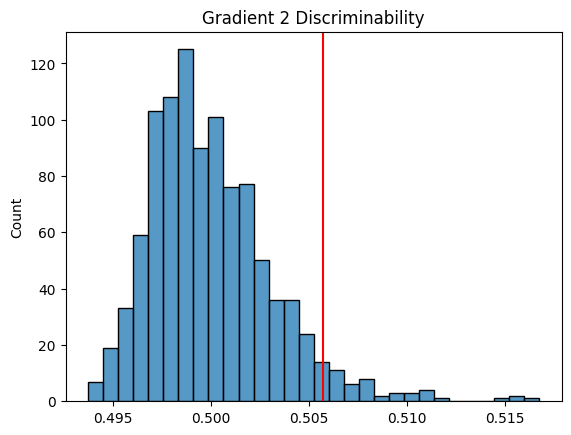

In [212]:
sns.histplot(grad_discrim[1][2])
plt.axvline(x = grad_discrim[1][0], c = "red")
plt.title("Gradient 2 Discriminability")

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Gradient 3 Discriminability')

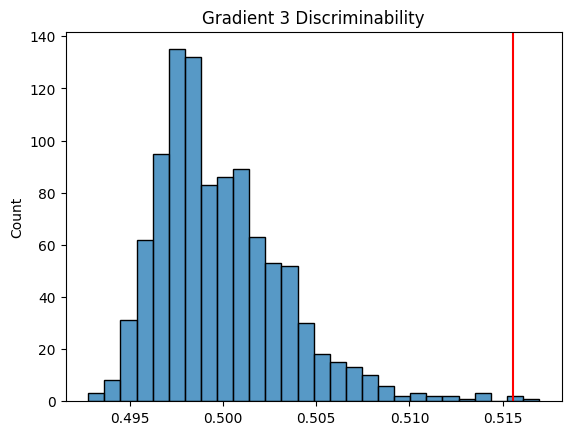

In [213]:
sns.histplot(grad_discrim[2][2])
plt.axvline(x = grad_discrim[2][0], c = "red")
plt.title("Gradient 3 Discriminability")

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Gradient 4 Discriminability')

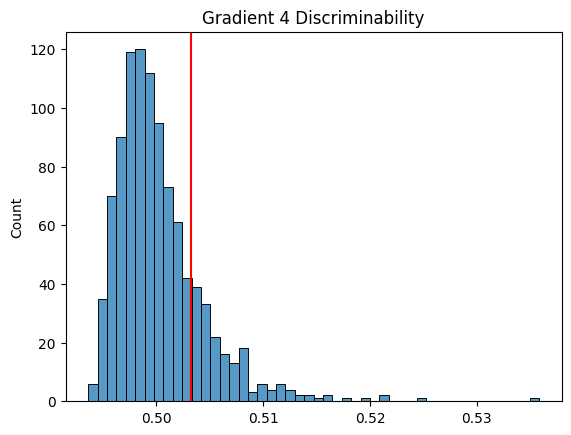

In [214]:
sns.histplot(grad_discrim[3][2])
plt.axvline(x = grad_discrim[3][0], c = "red")
plt.title("Gradient 4 Discriminability")

In [215]:
grad3_ses1.shape

(85, 1000)

In [220]:
grad1_dcorr= Dcorr().test(grad3[:85], grad3[85:])

In [221]:
grad1_dcorr

IndependenceTestOutput(stat=0.2731736853816433, pvalue=8.594580852661859e-07)

In [95]:
hcp_ngbrs = NearestNeighbors(n_neighbors=10, algorithm='brute').fit(grad_ses2)
distances, indices = hcp_ngbrs.kneighbors(grad_ses2)
subj_disp = distances.mean(axis = 1)

## Correlations of the 1st gradient

In [77]:
subj_corrs = []
for subject in np.arange(85):
    subj_corrs.append(np.corrcoef(grad1_ses1[subject, :], grad1_ses2[subject, :])[0][1])

subj_corrs = np.array(subj_corrs)


In [81]:
np.mean(subj_corrs)

0.8316894165228813

In [79]:
subj_dcorrs = []
for subject in np.arange(85):
    subj_dcorrs.append(Dcorr().test(grad1_ses1[subject, :], grad1_ses2[subject, :])[0])

subj_dcorrs = np.array(subj_dcorrs)

In [80]:
np.mean(subj_dcorrs)

0.6795343702737888

<Axes: >

Text(0.5, 0, 'Gradient 1, session 1')

Text(0, 0.5, 'Gradient 1, session 2')

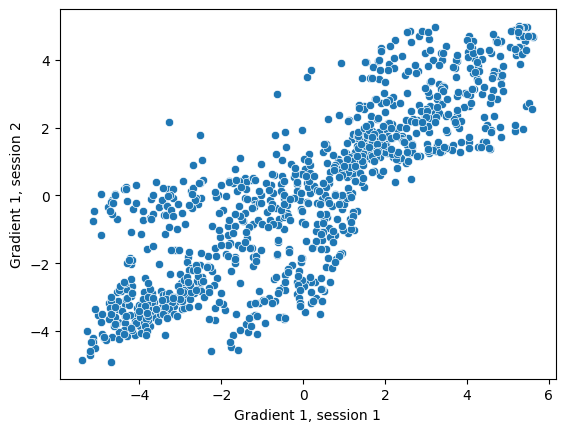

In [90]:
sns.scatterplot(x=grad1_ses1[72, :], y=grad1_ses2[72, :])
plt.xlabel('Gradient 1, session 1')
plt.ylabel('Gradient 1, session 2')

In [27]:
grad1_dcorr= Dcorr().test(grad[2], grad[2])

In [64]:
grad1[:85].shape

(85, 1000)

In [33]:
x = np.concatenate([np.zeros((85, 1000)), np.ones((85, 1000))], axis=0)
y = np.concatenate([np.zeros(85), np.ones(85)], axis=0)

example_result = DiscrimOneSample().test(x, y, workers=-1) 

<Axes: ylabel='Count'>

Text(0.5, 1.0, 'Perfect Discriminability')

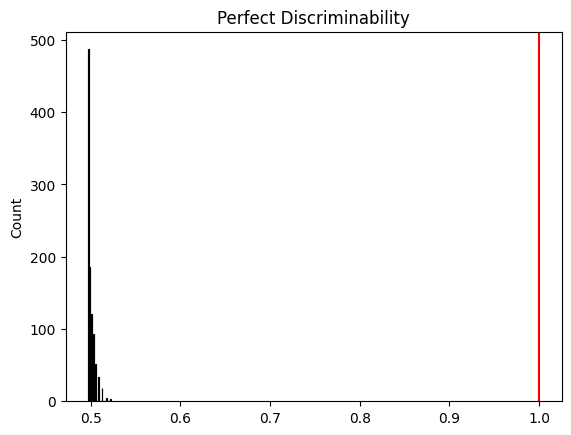

In [43]:
sns.histplot(example_result[2])
plt.axvline(x = example_result[0], c = "red")
plt.title("Perfect Discriminability")

In [46]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=1)
cca.fit(grad1[:85], grad1[85:])
r = cca.score(grad1[:85], grad1[85:])

CCA(n_components=1)

#### Correlations of dispersion

In [157]:
n_neighbours = 35
for subject in hcp_subjects:
    for i in range(1, 3):
        gradients = np.load(f'{path}/{subject}/func/aligned_3gradients_ses{i}_{subject}_schaefer1000.npy')
        hcp_ngbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(gradients)
        distances, indices = hcp_ngbrs.kneighbors(gradients)
        subj_disp = distances.mean(axis = 1)
        np.save(f'{path}/{subject}/func/dispersion_{n_neighbours}n_ses{i}_{subject}_schaefer1000.npy', subj_disp)

In [171]:
disp10_ses1 = np.array([np.load(f'{path}/{subject}/func/dispersion_15n_ses1_{subject}_schaefer1000.npy') for subject in hcp_subjects])
disp10_ses2 = np.array([np.load(f'{path}/{subject}/func/dispersion_15n_ses2_{subject}_schaefer1000.npy') for subject in hcp_subjects])

<Axes: >

Text(0.5, 0, 'Dispersion, session 1')

Text(0, 0.5, 'Dispersion, session 2')

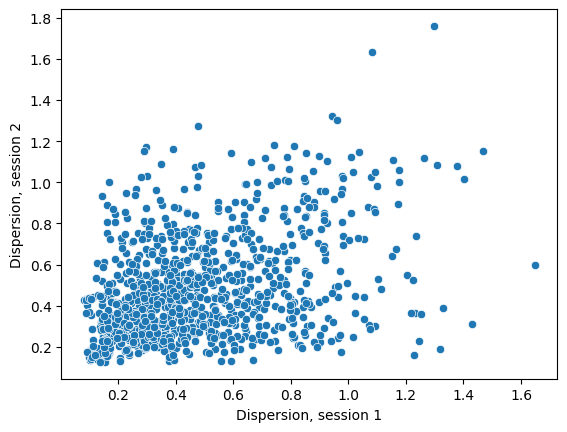

In [172]:
sns.scatterplot(x=disp10_ses1[2, :], y=disp10_ses2[2, :])
plt.xlabel('Dispersion, session 1')
plt.ylabel('Dispersion, session 2')

In [173]:
disp_corrs = []
for subject in np.arange(85):
    disp_corrs.append(np.corrcoef(disp10_ses1[subject, :], disp10_ses2[subject, :])[0][1])

disp_corrs = np.array(disp_corrs)

In [174]:
np.mean(disp_corrs)

0.42535172715291436

In [175]:
disp_dcorr= Dcorr().test(disp10_ses1, disp10_ses2)
disp_dcorr

IndependenceTestOutput(stat=0.39381595257736707, pvalue=4.319042723808022e-09)